In [1]:
import pickle , matplotlib.pyplot as plt, torch, numpy as np, argparse, time, os
from torch.utils.tensorboard.writer import SummaryWriter
from torch import optim
from torch.optim.lr_scheduler import StepLR
from src.TorchDSP.dataloader import signal_dataset, get_k_batch, get_signals
from src.TorchSimulation.receiver import  BER
from src.TorchDSP.pbc_new import NonlienarFeatures, FoPBC
train_path = "data/train_data_afterCDCDSP.pkl"
test_path = "data/test_data_afterCDCDSP.pkl"

train_p = -5 
test_p = -5
train_signal, train_truth, train_z = get_signals(train_path, Nch=1, Rs=20, Pch=[train_p],  device='cpu')
test_signal, test_truth, test_z = get_signals(test_path, Nch=1, Rs=20, Pch=[test_p], device='cpu')


class Model(object):
    def __init__(self, Nmodes, rho, L, index_type):
        self.Nmodes = Nmodes
        self.rho = rho
        self.L = L
        self.index_type = index_type
        self.features = NonlienarFeatures(Nmodes=self.Nmodes, rho=self.rho, L = self.L, index_type=self.index_type)
        self.C = torch.zeros(len(self.features.index), dtype=torch.complex64)

    def scatter(self, figsize=(10,10),dpi=400, s=3):
        x,y = zip(*self.features.index)
        values = np.log10(np.abs(self.C) + 1e-8)
        plt.figure(figsize=figsize, dpi=dpi)
        FoPBC(rho=self.rho, L=self.L, Nmodes=self.Nmodes, index_type=self.index_type).scatter_C(x,y,values)
        return 

    def scale(self, train_p, test_p):
        return 10 ** (test_p / 10) / 10 ** (train_p / 10)
    
    def fit(self, train_signal, train_truth, train_z, truncation=[0,-1], lamb_l2=0.1):
        s,e = truncation

        E = train_signal.val
        X_ = torch.squeeze(self.features(E, E, E))
        Y_ = torch.squeeze(train_signal.val - train_truth.val)
        X = X_[s:e]
        Y = Y_[s:e]
        A = (X.T.conj() @ X).real/X.shape[0] + lamb_l2 * torch.eye(X.shape[1])               # A.eig: 4e5 ~ 1e8
        b = (X.T.conj()) @ Y / X.shape[0]
        self.C = torch.linalg.solve(A, b.real) + 1j*torch.linalg.solve(A, b.imag)
        return self.C
    
    def predict(self, test_signal, train_p, test_p, xi=1):
        C = self.C * self.scale(train_p, test_p)
        E = test_signal.val
        X = torch.squeeze(self.features(E, E, E))
        return test_signal.val[0,:,0] - (torch.squeeze(self.features(test_signal.val, test_signal.val, test_signal.val)) @ C ) * self.scale(train_p, test_p)

    def test(self, test_signal, truth_signal, train_p, test_p, xi=1, BER_discard=1000):
        Yhat_test = self.predict(test_signal, train_p, test_p, xi)
        return BER(Yhat_test[BER_discard:,None], truth_signal.val[0,BER_discard:])


In [8]:
model = Model(Nmodes=1, rho=1,L=200, index_type='reduce-1')

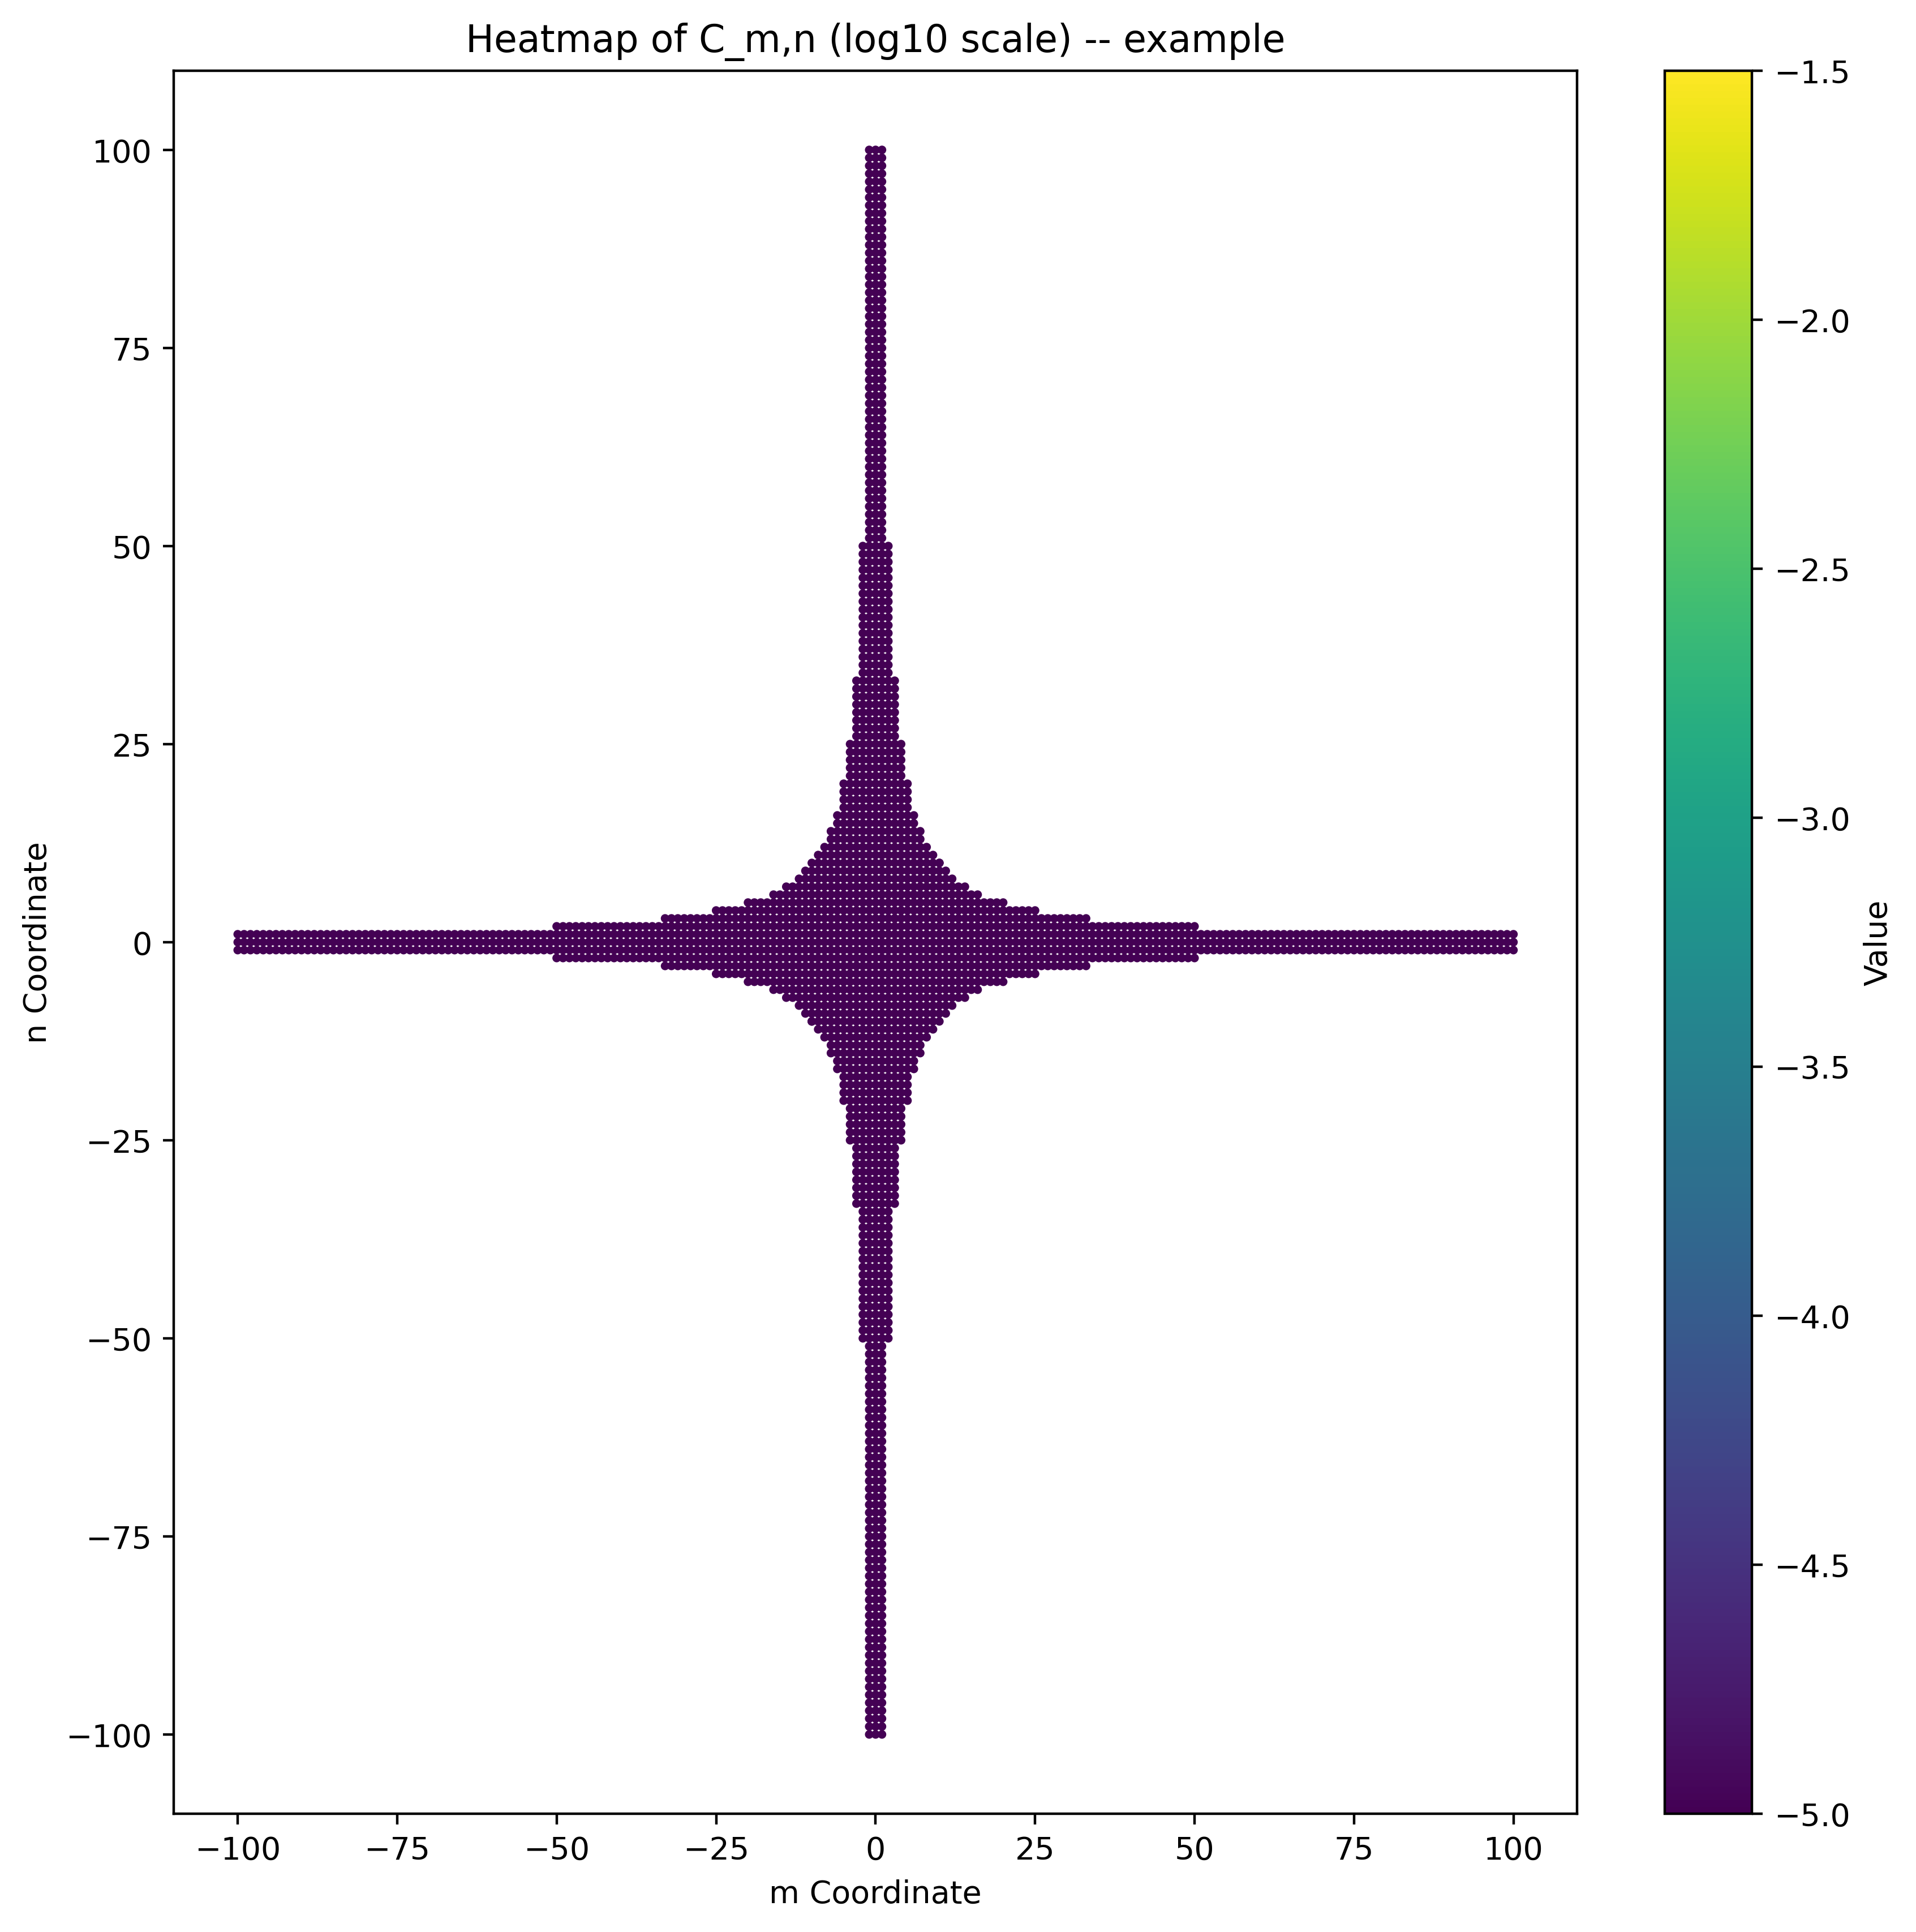

In [6]:
model.scatter()

# test

In [159]:
Yhat_train = train_signal.val[0,:,0] - X_ @ C
Yhat_test = test_signal.val[0,:,0] - (torch.squeeze(model(test_signal.val, test_signal.val, test_signal.val)) @ C ) * scale(train_p, test_p)

In [162]:
BER_discard = 20000
print('CDC(trainset): ')
print(BER(train_signal.val[0,BER_discard:,:], train_truth.val[0,BER_discard:]))

print('PBC(trainset): ')
print(BER(Yhat_train[BER_discard:,None], train_truth.val[0,BER_discard:]))

CDC(trainset): 
{'BER': array([0.00110022], dtype=float32), 'SER': array([0.00438838], dtype=float32), 'Qsq': array([9.719408], dtype=float32), 'SNR': array([16.936438], dtype=float32)}
PBC(trainset): 
{'BER': array([9.376875e-05], dtype=float32), 'SER': array([0.00037508], dtype=float32), 'Qsq': array([11.446366], dtype=float32), 'SNR': array([18.564608], dtype=float32)}


In [163]:
print('CDC(testset): ')
print(BER(test_signal.val[0,BER_discard:,:], test_truth.val[0,BER_discard:]))

print('PBC(testset): ')
print(BER(Yhat_test[BER_discard:,None], test_truth.val[0,BER_discard:]))

CDC(testset): 
{'BER': array([0.00110647], dtype=float32), 'SER': array([0.00442589], dtype=float32), 'Qsq': array([9.714592], dtype=float32), 'SNR': array([16.916296], dtype=float32)}
PBC(testset): 
{'BER': array([0.00010315], dtype=float32), 'SER': array([0.00041258], dtype=float32), 'Qsq': array([11.390252], dtype=float32), 'SNR': array([18.36456], dtype=float32)}


In [136]:
Qs = []
xis = np.linspace(0.9, 0.93, 10)

X_test = torch.squeeze(model(test_signal.val, test_signal.val, test_signal.val))
for xi in xis:
    Yhat_test = test_signal.val[0,:,0] - (X_test @ C ) * scale(train_p, test_p) * xi
    Qs.append(BER(Yhat_test[BER_discard:,None], test_truth.val[0,BER_discard:])['Qsq'])

In [164]:
Qs = []
xis = np.linspace(0.9, 1.1, 10)

X_train = torch.squeeze(model(train_signal.val, train_signal.val, train_signal.val))
for xi in xis:
    Yhat_train = train_signal.val[0,:,0] - (X_train @ C ) * scale(train_p, test_p) * xi
    Qs.append(BER(Yhat_train[BER_discard:,None], train_truth.val[0,BER_discard:])['Qsq'])

In [165]:
Qs

[array([11.427137], dtype=float32),
 array([11.427137], dtype=float32),
 array([11.427137], dtype=float32),
 array([11.427137], dtype=float32),
 array([11.427137], dtype=float32),
 array([11.427137], dtype=float32),
 array([11.466162], dtype=float32),
 array([11.446366], dtype=float32),
 array([11.427137], dtype=float32),
 array([11.408444], dtype=float32)]

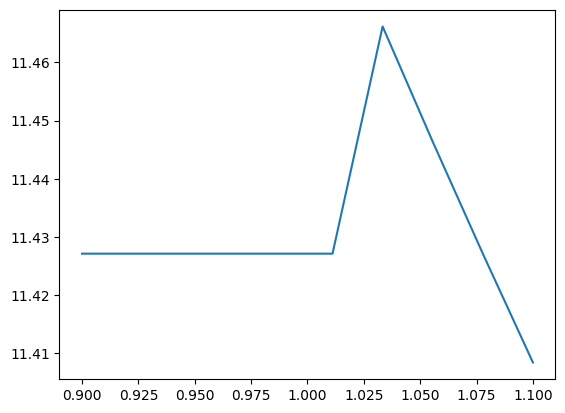

In [166]:
plt.plot(xis, Qs)